We will be looking at seq-to-seq model. We will use the seq-to-seq model to create a language translation for translating for english to french.

We will also be using attention mechanism.

We have many to many RNN architecture which can take a sequences and convert it into a length of different length.

We are going to be using encoder-decoder for creating a seq-to-seq model. Encoder takes the text and it builds a low dimension representation for the data also called context vector.

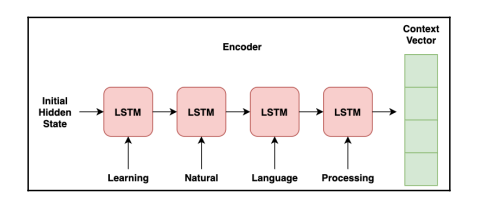

The output from the
encoder is the context vector, which contains two parts:


The hidden state from the last timestep of the encoder


The memory state of the LSTM for the input sentence


**Decoder:**
We get this Embedding from the encoder and we decode the context vector and then we will try to create a french representation for this.

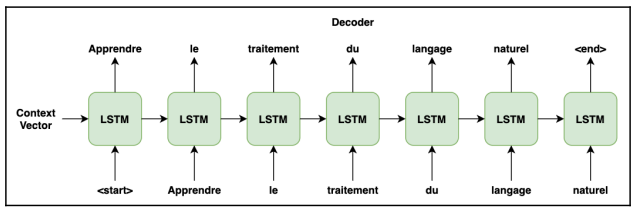
Up to now, we have seen that the initial hidden state for any RNN-based architecture is a
randomly initialized vector. However, with decoders, the input is the context vector that
we received as output from the encoder.
Okay, we have now understood that the initial hidden state should not be a randomly
initialized vector, but rather, the context vector. However, we still don't understand what
the input to the decoder should be.

The input to the decoder at the first timestep is a token that indicates the start of the
sentence, <start>. Using this <start> token, the decoder now has the task of learning to
predict the first token of the target sentence. However, the working of the decoder is a little
different for the learning and inferencing phases explained next. Let's understand that now.



**The training phase:**

During the training phase, the decoder has passed the target sequence as input along with
the context vector. The input to the decoder at timestep 0 is the <start> token. At timestep
1 the input to the decoder is the predicted token or the first token of the target sequence,
and so on. The decoder's job here is to learn that when provided a context vector and an
initial <start> token, it should be capable of producing a set of tokens.


**Inference phase:**


During the inference stage, we don't know what the target sequence should be and it is the
decoder's job to predict this target sequence. The decoder will receive the context vector
and the initial token using which it should be able to predict the first token. Thereon, it
should be able to predict the second token, using the first predicted token and the hidden
state from the first timestep, and this should continue as such. Essentially, the input at
timestep t is the predicted output of the previous timestep t-1, as shown in the diagram in
the Decoders section. The input at timestep 1 is Apprendre, which is actually the predicted
output from the previous timestep. The same pattern follows for the rest of the decoder's
work.

Whenever the output from a decoder state is a token indicating the end of the
sentence, <end>, or we have reached a pre-defined maximum length of output or target
sequence, we get a signal that the decoder has completed its job of building the output
sequence and we need to stop here.

In [ ]:
import pandas as pd
import numpy as np
import re
import io
import string
from unicodedata import normalize
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [ ]:
def read_data(file):
  data=[]
  with io.open(file, 'r') as file:
    for entry in file:
      entry= entry.strip()
      data.append(entry)
  return data
data=read_data('/content/bilingual_pairs.txt')

In [ ]:
data

['Go.\tVa !',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!',
 'Wow!\tÇa alors\u202f!',
 'Fire!\tAu feu !',
 "Help!\tÀ l'aide\u202f!",
 'Jump.\tSaute.',
 'Stop!\tÇa suffit\u202f!',
 'Stop!\tStop\u202f!',
 'Stop!\tArrête-toi !',
 'Wait!\tAttends !',
 'Wait!\tAttendez !',
 'I see.\tJe comprends.',
 "I try.\tJ'essaye.",
 "I won!\tJ'ai gagné !",
 "I won!\tJe l'ai emporté !",
 'Oh no!\tOh non !',
 'Attack!\tAttaque !',
 'Attack!\tAttaquez !',
 'Cheers!\tSanté !',
 'Cheers!\tÀ votre santé !',
 'Cheers!\tMerci !',
 'Cheers!\tTchin-tchin !',
 'Get up.\tLève-toi.',
 "Got it!\tJ'ai pigé !",
 'Got it!\tCompris !',
 'Got it?\tPigé\u202f?',
 'Got it?\tCompris\u202f?',
 "Got it?\tT'as capté\u202f?",
 'Hop in.\tMonte.',
 'Hop in.\tMontez.',
 'Hug me.\tSerre-moi dans tes bras !',
 'Hug me.\tSerrez-moi dans vos bras !',
 'I fell.\tJe suis tombée.',
 'I fell.\tJe suis tombé.',
 'I know.\tJe sais.',
 'I left.\tJe suis parti.',
 'I left.\tJe suis partie.',
 "I lost.\tJ'ai perdu.",
 "I'm 19.\tJ'ai 19 ans.",

In [ ]:
data[139990:140000]

['Never choose a vocation just because the hours are short.\tNe choisissez jamais une profession juste parce que les heures y sont courtes.',
 "No other mountain in the world is so high as Mt. Everest.\tAucune montagne au monde n'atteint la hauteur du Mont Everest.",
 "No sooner had he met his family than he burst into tears.\tÀ peine avait-il rencontré sa famille qu'il éclata en sanglots.",
 "Nothing is more disappointing than to lose in the finals.\tRien n'est plus décevant que de perdre en finale.",
 "Now that he is old, it is your duty to go look after him.\tÀ présent qu'il est vieux, c'est ton devoir de veiller sur lui.",
 "Now that you've decided to quit your job, you look happy.\tMaintenant que vous avez décidé de quitter votre emploi, vous avez l'air heureux.",
 "Now that you've decided to quit your job, you look happy.\tMaintenant que tu as décidé de quitter ton emploi, tu as l'air heureux.",
 "Now that you've decided to quit your job, you look happy.\tMaintenant que vous avez

In [ ]:
len(data)

145437

In [ ]:
data=data[:140000]

Since our dataset contains tabs that seperate the English-French sentence pairs, so we need to split them into different English and French list

In [ ]:
def build_english_french_sentences(data):
  english_sentences=[]
  french_sentences=[]
  for data_points in data:
    english_sentences.append(data_points.split("\t")[0])
    french_sentences.append(data_points.split("\t")[1])
  return english_sentences, french_sentences
english_sentences, french_sentences=build_english_french_sentences(data)

In [ ]:
len(english_sentences)


140000

In [ ]:
len(french_sentences)

140000

Data cleaning

In [ ]:
def clean_sentences(sentence):
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    cleaned_sent = normalize('NFD', sentence).encode('ascii', 'ignore')
    cleaned_sent = cleaned_sent.decode('UTF-8')
    cleaned_sent = cleaned_sent.split()
    cleaned_sent = [word.lower() for word in cleaned_sent]
    cleaned_sent = [word.translate(table) for word in cleaned_sent]
    cleaned_sent = [re_print.sub('', w) for w in cleaned_sent]
    cleaned_sent = [word for word in cleaned_sent if word.isalpha()]
    return ' '.join(cleaned_sent)

In [ ]:
def build_clean_english_french_sentences(english_sentences, french_sentences):
    french_sentences_cleaned = []
    english_sentences_cleaned = []
    for sent in french_sentences:
        french_sentences_cleaned.append(clean_sentences(sent))
    for sent in english_sentences:
        english_sentences_cleaned.append(clean_sentences(sent))
    return english_sentences_cleaned, french_sentences_cleaned

In [ ]:
english_sentences_cleaned, french_sentences_cleaned = build_clean_english_french_sentences(english_sentences, french_sentences)

In [ ]:
english_sentences_cleaned[40884]

'i think i can fix this'

The following steps are where we
build our vocabulary and also add tokens that convey the start and end of a
sequence, as required by our decoder

In [ ]:
def build_data(english_sentences_cleaned, french_sentences_cleaned):
    input_dataset = []
    target_dataset = []
    input_characters = set()
    target_characters = set()

    for french_sentence in french_sentences_cleaned:
        input_datapoint = french_sentence
        input_dataset.append(input_datapoint)
        for char in input_datapoint:
            input_characters.add(char)

    for english_sentence in english_sentences_cleaned:
        target_datapoint = "\t" + english_sentence + "\n"
        target_dataset.append(target_datapoint)
        for char in target_datapoint:
            target_characters.add(char)

    return input_dataset, target_dataset, sorted(list(input_characters)), sorted(list(target_characters))

In [ ]:
input_dataset, target_dataset, input_characters, target_characters = build_data(english_sentences_cleaned,
                                                                                french_sentences_cleaned)

In [ ]:
len(input_characters)

27

In [ ]:
len(target_characters)

29

The method defined in the previous code block helped us to do the following:
Add \t to our target data to convey the start of a sentence to our decoder.
Add \n to our target data to convey the end of a sentence to our decoder.
Prepare a list of unique input and output characters. Our model will try and
predict at the character level for this exercise.


In [ ]:
print(input_characters)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
print(target_characters)

['\t', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


 the target character dataset has
\t and \n tokens, which help the decoder to understand the start and end of a
target sequence.

The English sentence how are you today, dear? is written in French as comment tu vas
aujourd'hui mon cher.


The number of words in the preceding sentences is different. If we go to the
character level, then we can see that the number of characters in both sentences is
very different as well.
Let's take another very similar English sentence, how are you today? which is
written in French as comment vas-tu aujourd'hui? Now, if we make a comparison
between the two examples we discussed, their English and French counterparts
have differing lengths.

We next want to find out some metadata about our data, in terms of the
following:


The size of the input and target vocabularies (basically, the size of the input
and target character sets)


The maximum length of input and output character sequences

In [ ]:
def build_metadata(input_dataset, target_dataset, input_characters, target_characters):
    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    max_encoder_seq_length = max([len(data_point) for data_point in input_dataset])
    max_decoder_seq_length = max([len(data_point) for data_point in target_dataset])

    print('Number of data points:', len(input_dataset))
    print('Number of unique input tokens:', num_encoder_tokens)
    print('Number of unique output tokens:', num_decoder_tokens)
    print('Maximum sequence length for inputs:', max_encoder_seq_length)
    print('Maximum sequence length for outputs:', max_decoder_seq_length)

    return num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length

In [ ]:
num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = build_metadata(input_dataset,
                                                                                                        target_dataset,
                                                                                                        input_characters,
                                                                                                        target_characters)

Number of data points: 140000
Number of unique input tokens: 27
Number of unique output tokens: 29
Maximum sequence length for inputs: 117
Maximum sequence length for outputs: 58


**Developing mappings for character to index and vice-versa**

Here's what we get from the metadata:
We have 140,000 unique English-French sentence pairs in our dataset.
The number of unique input tokens/characters is 27.
The number of unique target tokens/characters that we'll try and predict is
29.
Our longest input character sequence is 117 characters long.
Our longest target character sequence is 58 characters long.

A very important step is to build mappings from characters to indices and vice
versa. This will help us to do the following:
Represent our input characters using their corresponding indices
Convert our predicted indices into their corresponding characters when
making predictions

In [ ]:
def build_indices(input_characters, target_characters):
    input_char_to_idx = {}
    input_idx_to_char = {}
    target_char_to_idx = {}
    target_idx_to_char = {}

    for i, char in enumerate(input_characters):
        input_char_to_idx[char] = i
        input_idx_to_char[i] = char

    for i, char in enumerate(target_characters):
        target_char_to_idx[char] = i
        target_idx_to_char[i] = char

    return input_char_to_idx, input_idx_to_char, target_char_to_idx, target_idx_to_char

input_char_to_idx, input_idx_to_char, target_char_to_idx, target_idx_to_char = build_indices(input_characters,
                                                                                             target_characters)

**Building data structure to accomodate data**

In [ ]:

def build_data_structures(length_input_dataset, max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens):
    encoder_input_data = np.zeros((length_input_dataset, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    decoder_input_data = np.zeros((length_input_dataset, max_decoder_seq_length, num_decoder_tokens), dtype='float32')
    decoder_target_data = np.zeros((length_input_dataset, max_decoder_seq_length, num_decoder_tokens), dtype='float32')
    print("Dimensionality of encoder input data is : ", encoder_input_data.shape)
    print("Dimensionality of decoder input data is : ", decoder_input_data.shape)
    print("Dimensionality of decoder target data is : ", decoder_target_data.shape)

    return encoder_input_data, decoder_input_data, decoder_target_data

encoder_input_data, decoder_input_data, decoder_target_data = build_data_structures(len(input_dataset),
                                                                                    max_encoder_seq_length,
                                                                                    max_decoder_seq_length,
                                                                                    num_encoder_tokens,
                                                                                    num_decoder_tokens)

Dimensionality of encoder input data is :  (140000, 117, 27)
Dimensionality of decoder input data is :  (140000, 58, 29)
Dimensionality of decoder target data is :  (140000, 58, 29)


The dimensionality of the input data is (140000, 117, 27):


The first dimension caters to the number of data points we have:
140,000.


The second dimension caters to the maximum length of our input
sequence: 117.


The third dimension caters to the number of unique inputs we can have
or the size of our input character set: 27.


The dimensionality of the decoder input and decoder target data is
(140000, 58, 29):


The first dimension caters to the number of data points we have:
140,000.

The second dimension caters to the maximum length of our target
sequence: 58.

The third dimension caters to the number of unique inputs we can have
or the size of our target character set: 29

In [ ]:
def add_data_to_data_structures(input_dataset, target_dataset, encoder_input_data, decoder_input_data, decoder_target_data):
    for i, (input_data_point, target_data_point) in enumerate(zip(input_dataset, target_dataset)):
        for t, char in enumerate(input_data_point):
            encoder_input_data[i, t, input_char_to_idx[char]] = 1.
        for t, char in enumerate(target_data_point):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_char_to_idx[char]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_char_to_idx[char]] = 1.
    return encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data = add_data_to_data_structures(input_dataset,
                                                                                          target_dataset,
                                                                                          encoder_input_data,
                                                                                          decoder_input_data,
                                                                                          decoder_target_data)

We have used the character-to-indices mapping and converted some entries in
our data structure to 1, which indicates the presence of a particular character at a
specific position in each of the sentences.
If you carefully examine our work so far, notice that the last dimension (27 in the
encoder input data structure and 29 in the decoder input or decoder target) is a
one-hot vector, which indicates which entry is present for that particular position
in our data.
One final thing to note is that when building the decoder target data, we do not
include anything for the <start> token, and it is also ahead by one timestep for
the same reasons that we discussed when talking about decoders in the previous
section.
Our decoder target data is the same as the decoder input data, except that it is
offset by one timestep.

In [ ]:
#hyperparameter for our model
batch_size=256
epochs=100
latent_dim=256


In [ ]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

We have set return_ state as True so that the decoder returns us the last
hidden state and memory, which will form the context vector.
state_h and state_c represent our last hidden state and memory cell,
respectively.
However, how does our encoder learn?
The encoder's job is to provide a context vector where it captures the context or
thought in the input sentence. However, we do not have any explicit target
context vector defined against which to compare the encoder's performance. The
encoder learns from the performance of the decoder, which happens further
down the line. The decoder's error flows back and that's how the backpropagation
in the encoder works and it learns.

In [ ]:
#decoder of our architecure
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

A dense layer is part of the decoder where the number of neurons is equal to the
number of tokens (characters in our case) present in the decoder's target character
set. The dense layer is coupled with the softmax output that helps us to get the
normalized probabilities for every target character. It predicts the target character
with the highest probability.

The return_sequences parameter in the decoder LSTM helps us to retrieve the
entire output sequence from the decoder. We want an output from the decoder at
every timestep and that is why we set this parameter to True. Since we used the
dense layer along with the softmax output, we get a probability distribution over
our target characters for every timestep, and as mentioned already, we pick the
character with the highest probability. We judge the performance of our decoder
by comparing its output produced at every timestep.


Building a model


In [ ]:
model = Model(inputs=[encoder_inputs, decoder_inputs],
              outputs=decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 27)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 29)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                290816    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [ ]:

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
438/438 [==============================] - 24s 47ms/step - loss: 1.2475 - val_loss: 2.1986
Epoch 2/100
438/438 [==============================] - 17s 40ms/step - loss: 1.1812 - val_loss: 2.1283
Epoch 3/100
438/438 [==============================] - 18s 40ms/step - loss: 1.1288 - val_loss: 2.0714
Epoch 4/100
438/438 [==============================] - 18s 41ms/step - loss: 1.0914 - val_loss: 2.0421
Epoch 5/100
438/438 [==============================] - 18s 42ms/step - loss: 1.0645 - val_loss: 2.0492
Epoch 6/100
438/438 [==============================] - 18s 42ms/step - loss: 1.0445 - val_loss: 1.9870
Epoch 7/100
438/438 [==============================] - 19s 43ms/step - loss: 1.0275 - val_loss: 1.9718
Epoch 8/100
438/438 [==============================] - 19s 43ms/step - loss: 1.0138 - val_loss: 2.0066
Epoch 9/100
438/438 [==============================] - 18s 42ms/step - loss: 1.0019 - val_loss: 1.9419
Epoch 10/100
438/438 [==============================] - 18s 42ms/step - l

In [ ]:
model.save('French_translation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Inference**

1.  We send the input sequence to the encoder and retrieve the initial
decoder state.
2. After this, we send the start token (\t in our case) and the initial
decoder state to the decoder to get the next target character as the
output.
3. We then add the predicted target character to the sequence.
4. Repeat from step 2 until we obtain the end token or reach the maximum
number of predicted characters:



In [ ]:

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_seq):

    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_char_to_idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_idx_to_char[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
              stop_condition = True


        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

**Let's translate some French sentences to English**

In [ ]:
def decode(seq_index):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_dataset[seq_index])
    print('Decoded sentence:', decoded_sentence)

In [ ]:
decode(5500)

1/1 [==============================] - 0s 19ms/step
-
Input sentence: merci tout de meme
Decoded sentence: i dont know what the a the o o o o o o o o o o o o o o o o 


In [ ]:
decode(10000)

1/1 [==============================] - 0s 20ms/step
-
Input sentence: jen ai ras le bol
Decoded sentence: i dont know what the a the o o o o o o o o o o o o o o o o 


**Let's pay a attention now **

The encoder-decoder architecture that we studied in the previous section for neural
machine translation converted our source text into a fixed-length context vector and sent it
to the decoder. The last hidden state was used by our decoder to build the target sequence.
Research has shown that this approach of sending the last hidden state turns out to be a
bottleneck for long sentences, especially where the length of the sentence is longer than the
sentences used for training. The context vector is not able to capture the meaning of the
entire sentence. The performance of the model is not good and keeps deteriorating in such
cases.

A new mechanism called the attention mechanism, shown in the following
diagram, evolved to solve this problem of dealing with long sentences. Instead of sending
only the last hidden state to the decoder, all the hidden states are passed on to the decoder.
This approach provides the ability to encode an input sequence into a sequence of vectors
without being constrained to a single fixed-length vector as was the case earlier

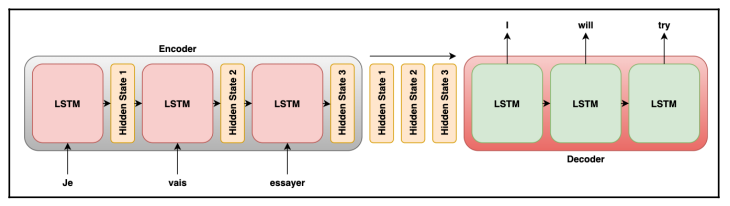

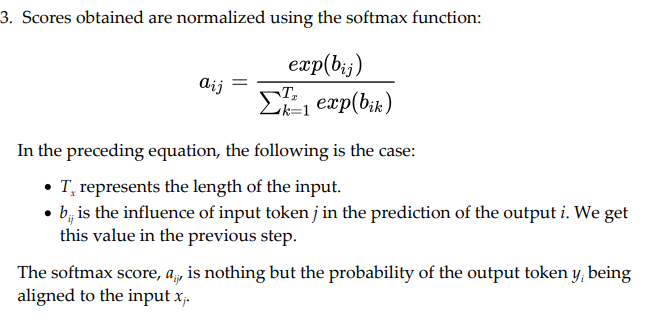